In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

## Динамический метод (первичные экпериментальные данные + обработка)

In [59]:
import random

dynamic = mipt.read_excel('data/5.2.1.xlsx', usecols=('N', 'O', 'P'), header=(0)).dropna()
dynamic

dVs_tab = pd.DataFrame(columns=['dVmax1', 'dVmin1', 'dVmax2', 'dVmin2']) # to export
dVs = np.array([]) # to use later, linear
dVs_err = np.array([]) # to use later, linear

kostil_do_not_use_i = 0

# Похер уже
fmt = {
    (r'$U = 4$ В', 'x_i') : [r'$x_i$, В', '{:.1f}', 0],
    (r'$U = 4$ В', 'dx_i') : [r'$\sigma_{x_i}$, В', '{:.1f}', 0],
    (r'$U = 6$ В', 'x_i') : [r'$x_i$, В', '{:.1f}', 0],
    (r'$U = 6$ В', 'dx_i') : [r'$\sigma_{x_i}$, В', '{:.1f}', 0],
    (r'$U = 8$ В', 'x_i') : [r'$x_i$, В', '{:.1f}', 0],
    (r'$U = 8$ В', 'dx_i') : [r'$\sigma_{x_i}$, В', '{:.1f}', 0],
}

def do_dyn_shit(x):
    x_err = 0.7 * x**0 + np.random.rand(len(x)) * 0.4
                                
    
    __export = pd.concat([
        x.rename('x_i'),
        x_err.rename('dx_i'),
    ], axis=1)
    
    dV_row = [x[i+2] - x[i] for i in range(len(x) - 2) if i < len(x)//4 or i >= len(x)//2] # Do not know why, sorry
    dV_row_err = [math.sqrt(x_err[i+2]**2 + x_err[i]**2) for i in range(len(x) - 2) if i < len(x)//4 or i >= len(x)//2]
    
    global dVs, dVs_err, dVs_tab, kostil_do_not_use_i
    dVs_tab.loc[kostil_do_not_use_i] = dV_row
    kostil_do_not_use_i += 1
    dVs = np.append(dVs, dV_row)
    dVs_err = np.append(dVs_err, dV_row_err)
    
    tab = mipt.table(__export, fmt)
    
    return __export #tab.rename().data

d = { r'$U = 4$ В' : do_dyn_shit(dynamic['Udyn=4']), 
      r'$U = 6$ В' : do_dyn_shit(dynamic['Udyn=6']),
      r'$U = 8$ В' : do_dyn_shit(dynamic['Udyn=8']) }

export = pd.concat(d.values(), axis=1, keys=d.keys())

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-dynamic-xi.tex')

fmt = {
    ('dVmax1') : [r'$\Delta V_{max}^{(1)}$, В', '{:.1f}', 0],
    ('dVmax2') : [r'$\Delta V_{max}^{(2)}$, В', '{:.1f}', 0],
    ('dVmin1') : [r'$\Delta V_{max}^{(1)}$, В', '{:.1f}', 0],
    ('dVmin2') : [r'$\Delta V_{max}^{(2)}$, В', '{:.1f}', 0],
}

dVs_tab.insert(0, '$U,$ В', [4, 6, 8])
tab = mipt.table(dVs_tab, fmt)
tab.to_latex('gen/tab-dynamic-dvs.tex')
tab.data

print("<dV> = {} \pm {}".format(dVs.mean(), math.sqrt(dVs.std()**2 + dVs_err.mean()**2)))

dVs.mean

<dV> = 16.24903666666667 \pm 2.456473526426997


<function ndarray.mean>

## Статический метод (первичные данные + обработка)

[23.  14.5 21.5 14.  13.5 19.5]
17.666666666666668
3.815174380753199
3.9440531887330774

[0.33372108 0.33372108 0.33372581]
[0.3337849  0.33379001 0.33379516]
[0.471998   0.47200162 0.47200861]


,dVmax,dVmin
0,23.0,14.5
1,21.5,14.0
2,13.5,19.5


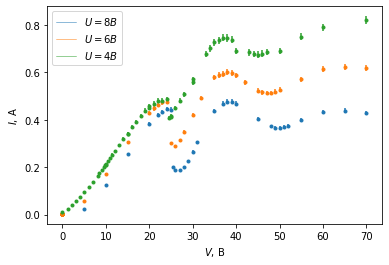

In [33]:
static = mipt.read_excel('data/5.2.1.xlsx', usecols=('E', 'F', 'H', 'I', 'K', 'L'), header=(0,1)).dropna()
static

from scipy.interpolate import interp1d
#    return interp1d(x, y, kind='cubic')
#print(static["U=4"])
dVs_tab = pd.DataFrame(columns=['dVmax', 'dVmin']) # to export
dVs = np.array([]) # to use later, linear
dVs_err = np.array([]) # to use later, linear

from scipy.interpolate import UnivariateSpline
def interp(x, y):
    return UnivariateSpline(x, y, s = 0.0002)

kostil_do_not_use_i = 0

def do_static_shit(data, label, mins, maxs):
    data = data.sort_values(by=['U']).reset_index(drop=True)
    #print(data)
    u = data['U']
    u_err = ((0.03/100 * u + 0.04)**2 + (0.01)**2)**0.5
    
    i = data['I']
    i_err = ((0.3/100 * i + 0.0002)**2 + (i * 0.02)**2)**0.5

    #print(u)
    for st in range(0, len(i_err)):
        if (str(i_err[st]).startswith("0.000") == True):
            i_err[st] = 0.001

    mipt.plot(u, i, func=None, marker_size=6, exclude=[], label=label, xerr = u_err, yerr = i_err, linewidth=0.5)

    #for m in mins:
    #     plt.axvline(m, linewidth=0.5, ls = ':', color=plt.gca().lines[-1].get_color())
    #for m in maxs:
    #    plt.axvline(m, linewidth=0.5, ls = ':', color=plt.gca().lines[-1].get_color())
    
    dV_row = []
    dV_row.extend([mins[i+1] - mins[i] for i in range(len(mins) - 1)])
    dV_row.extend([maxs[i+1] - maxs[i] for i in range(len(maxs) - 1)])
    
    global dVs, dVs_tab, kostil_do_not_use_i
    dVs_tab.loc[kostil_do_not_use_i] = dV_row
    kostil_do_not_use_i += 1
    
    dVs = np.append(dVs, dV_row)
    
    __export = pd.concat([
        u.rename('u'),
        u_err.rename('du'),
        i.rename('i'),
        i_err.rename('di'),
    ], axis=1)
    
    plt.xlabel(r"$V$, В")
    plt.ylabel(r"$I$, А")

    plt.legend()

    plt.savefig('gen/fig-vi.pdf')
    
    return __export
    
# Чего только не придумаешь...
def get_fmt(label):
    return {
        (label, 'u') : [r'$U$, В', '{:.2f}', 0],
        (label, 'du') : [r'$\sigma_{U}$, В', '{:.2f}', 0],
        (label, 'i') : [r'$I$, А', '{:.3f}', 0],
        (label, 'di') : [r'$\sigma_{I}$, А', '{:.3f}', 0],
    }

def export_this(number, mins, maxs):
    d = { r'$U = {}$ В'.format(number) : do_static_shit(static['U={}'.format(number)], '$U = {} В$'.format(number), mins, maxs) }
    export = pd.concat(d.values(), axis=1, keys=d.keys()).drop_duplicates()
    tab = mipt.table(export, get_fmt(r'$U = {}$ В'.format(number)))
    tab.to_latex('gen/tab-dynamic-{}.tex'.format(number))

export_this(8, (27, 50), (23.5, 38))
export_this(6, (26, 47.5), (23.5, 37.5))
export_this(4, (23.5, 37), (25, 44.5))

experimenter_hands_err = 1

def sigu(u):
    return ((0.03/100 * u + 0.04)**2 + (0.01)**2 + 1)**0.5 / 3

def sig2u(sigu1, sigu2):
    return (sigu1**2 + sigu2**2)**0.5

#dVs = np.array([
#    37 - 24,
#    38 - 24,
#    39 - 25
#])
print(dVs)
print(dVs.mean())
print(dVs.std())
print(math.sqrt(dVs.std()**2 + experimenter_hands_err**2))
print()

sigu1 = sigu(np.array([24, 24, 25]))
sigu2 = sigu(np.array([37, 38, 39]))

print(sigu1)
print(sigu2)

print(sig2u(sigu1, sigu2))

dVs_tab